In [ ]:
!pip install 'scipy>=1.8'
!pip install 'networkx<2.7'
!pip install igraph
!pip install pandas==1.5.3
!pip install infomap
!pip install 'numpy<1.23.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.2 MB/s eta 0:00:0000:010:01
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
scikit-image 0.21.0 requires networkx>=2.8, but you have networkx 2.6.3 which is incompatible.
ydata-profiling 4.5.1 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 76.5 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently tak

Importing Libraries


In [ ]:

from collections import Counter


import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline,make_pipeline
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import warnings
warnings.filterwarnings('ignore')
import networkx as nx
import infomap

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
PATH = '/kaggle/input/healthcare-provider-fraud-detection-analysis/'

In [ ]:
inpatients = pd.read_csv(PATH + 'Train_Inpatientdata-1542865627584.csv')
outpatients = pd.read_csv(PATH + 'Train_Outpatientdata-1542865627584.csv')
beneficiaries = pd.read_csv(PATH + 'Train_Beneficiarydata-1542865627584.csv')

labels = pd.read_csv(PATH + 'Train-1542865627584.csv')

In [ ]:
df1 = inpatients[['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician','DeductibleAmtPaid']]
df2 = outpatients[['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'DeductibleAmtPaid']]
df3 = beneficiaries[['BeneID', 'Gender', 'Race', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']]


df = pd.concat([df1, df2])

df = df.set_index('Provider').join(labels.set_index('Provider')).reset_index().set_index('BeneID').join(df3.set_index('BeneID')).reset_index()

df['PotentialFraud'] = df['PotentialFraud'].replace("No", 0).replace("Yes", 1).astype(int)

df.head()

,BeneID,Provider,ClaimID,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid,PotentialFraud,Gender,Race,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE100000,PRV57172,CLM126832,50,PHY383401,0.0,1,1,1,12,12,0,0,120,30
1,BENE100000,PRV57172,CLM351838,70,PHY370909,0.0,1,1,1,12,12,0,0,120,30
2,BENE100001,PRV52145,CLM626521,10,PHY430032,0.0,0,1,1,12,12,0,0,2530,540
3,BENE100001,PRV54683,CLM633318,100,PHY408282,0.0,0,1,1,12,12,0,0,2530,540
4,BENE100001,PRV54890,CLM332544,90,PHY343317,0.0,0,1,1,12,12,0,0,2530,540


In [ ]:
df['AttendingPhysician'].str.removeprefix("PHY").astype(float).min()

311001.0

In [ ]:
df['Provider'] = df['Provider'].str.removeprefix("PRV").astype(int) + 1_000_000
df['AttendingPhysician'] = df['AttendingPhysician'].str.removeprefix("PHY").fillna(0).astype(int) + 2_000_000
df

,BeneID,Provider,ClaimID,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid,PotentialFraud,Gender,Race,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE100000,1057172,CLM126832,50,2383401,0.0,1,1,1,12,12,0,0,120,30
1,BENE100000,1057172,CLM351838,70,2370909,0.0,1,1,1,12,12,0,0,120,30
2,BENE100001,1052145,CLM626521,10,2430032,0.0,0,1,1,12,12,0,0,2530,540
3,BENE100001,1054683,CLM633318,100,2408282,0.0,0,1,1,12,12,0,0,2530,540
4,BENE100001,1054890,CLM332544,90,2343317,0.0,0,1,1,12,12,0,0,2530,540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE99999,1054670,CLM475422,80,2351000,0.0,0,2,1,12,12,0,0,1270,690
558207,BENE99999,1054670,CLM750563,50,2359641,0.0,0,2,1,12,12,0,0,1270,690
558208,BENE99999,1055510,CLM187739,60,2318212,0.0,0,2,1,12,12,0,0,1270,690
558209,BENE99999,1055826,CLM359214,80,2341548,0.0,0,2,1,12,12,0,0,1270,690


In [ ]:
df['BeneID'] = df['BeneID'].str.removeprefix("BENE").astype(int) + 3_000_000

In [ ]:
df['ClaimID'] = df['ClaimID'].str.removeprefix("CLM").astype(int) + 4_000_000

In [ ]:
source = 'Provider'
target = 'AttendingPhysician'

G = nx.from_pandas_edgelist(df, source=source, target = target)

In [ ]:
import plotly.graph_objs as go

df_plotting = df.sample(n=1_000, random_state=1)

H = nx.from_pandas_edgelist(df_plotting, source=source, target = target)
pos = nx.random_layout(H)

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#010203'),
    hoverinfo='none',
    mode='lines')

for edge in H.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    mode='markers',
    marker=dict(
        showscale=True,
        colorscale='RdBu',
        reversescale=False,
        color=[],
        size=12,
        colorbar=dict(
            thickness=35,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in H.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])


#add color to node points
for node, adjacencies in enumerate(H.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network Graph of Provider & Physician \n\n',
                titlefont=dict(size=16),
                showlegend=False,
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()


In [ ]:

nodes_info_dict = {
  'eigenvector_centrality': nx.eigenvector_centrality_numpy,
  'pagerank': nx.pagerank
}

columns_with_node_infos = ['degree'] + list(nodes_info_dict.keys())

nodes_info = pd.DataFrame.from_dict(dict(nx.degree(G)), orient='index').rename(columns = {0 : 'degree'}).reset_index()

for info, fun in nodes_info_dict.items():
    temp = pd.DataFrame.from_dict(fun(G), orient='index').rename(columns = {0 : info}).reset_index()
    nodes_info = nodes_info.merge(temp, on='index')

nodes_info = nodes_info.rename(columns = {'index': 'Physician'})

df_enriched = df.merge(nodes_info, left_on = 'Provider',
                           right_on='Physician', how='left').drop('Physician', axis=1)
df_enriched.rename(columns = {k:'Provider_'+k for k in columns_with_node_infos}, inplace = True)

df_enriched = df_enriched.merge(nodes_info, left_on = 'AttendingPhysician',
                           right_on='Physician', how='left').drop('Physician', axis=1)
df_enriched.rename(columns = {k:'AttendingPhysician_'+k for k in columns_with_node_infos}, inplace = True)

In [ ]:
df_enriched.head()

,BeneID,Provider,ClaimID,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid,PotentialFraud,Gender,Race,NoOfMonths_PartACov,...,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Provider_degree,Provider_eigenvector_centrality,Provider_pagerank,AttendingPhysician_degree,AttendingPhysician_eigenvector_centrality,AttendingPhysician_pagerank
0,3100000,1057172,4126832,50,2383401,0.0,1,1,1,12,...,0,0,120,30,105,0.025261,0.000560,1,0.000821,0.000006
1,3100000,1057172,4351838,70,2370909,0.0,1,1,1,12,...,0,0,120,30,105,0.025261,0.000560,1,0.000821,0.000006
2,3100001,1052145,4626521,10,2430032,0.0,0,1,1,12,...,0,0,2530,540,51,0.023621,0.000280,1,0.000768,0.000006
3,3100001,1054683,4633318,100,2408282,0.0,0,1,1,12,...,0,0,2530,540,140,0.000059,0.000765,1,0.000002,0.000006
4,3100001,1054890,4332544,90,2343317,0.0,0,1,1,12,...,0,0,2530,540,54,0.023700,0.000294,1,0.000771,0.000006


In [ ]:
df_enriched.shape

(558211, 21)

In [ ]:
def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    im = infomap.Infomap(two_level=True, silent=True)

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges():
        im.addLink(*e)

    print("Find communities with Infomap...")
    im.run();

    print(f"Found {im.num_top_modules} modules with codelength {im.codelength:.8f} bits")

    communities = {}
    for node, module in im.modules:
        communities[node] = module

    nx.set_node_attributes(G, communities, 'community')

    return G

def drawNetwork(G):
    pos = nx.spectral_layout(I)
    communities = [v for k,v in nx.get_node_attributes(I, 'community').items()]
    numCommunities = max(communities) + 1
    cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', numCommunities)

    # Draw edges
    nx.draw_networkx_edges(I, pos)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(I,
      pos = pos,
      node_size=1,
      node_color = communities,
      cmap = cmapLight
    )
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    plt.axis('off')
    plt.xlim(np.vstack(list(pos.values()))[:, 0].min() + 0.01, np.vstack(list(pos.values()))[:, 0].max())
    plt.ylim(np.vstack(list(pos.values()))[:, 1].min(), np.vstack(list(pos.values()))[:, 1].max())
    plt.show()

In [ ]:
G = findCommunities(G)

Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 4350 modules with codelength 4.48294618 bits


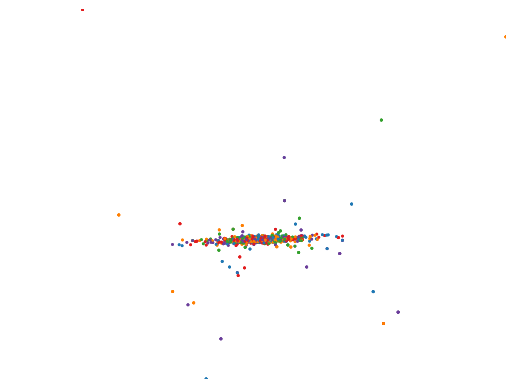

In [ ]:
I = G.subgraph(list(H.nodes()))

drawNetwork(I)

In [ ]:
df_communities = pd.DataFrame([[k, v]  for k, v in nx.get_node_attributes(G, 'community').items()], columns=["AttendingPhysician", "AttendingPhysician_cluster"])
df_communities.head(2)

,AttendingPhysician,AttendingPhysician_cluster
0,1057172,106
1,2383401,106


In [ ]:
df_communities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87474 entries, 0 to 87473
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   AttendingPhysician          87474 non-null  int64
 1   AttendingPhysician_cluster  87474 non-null  int64
dtypes: int64(2)
memory usage: 1.3 MB


In [ ]:
df_enriched = df_enriched.set_index('AttendingPhysician').join(df_communities.set_index('AttendingPhysician'), how="left", rsuffix='_comm').reset_index()

df_enriched.head(2)

,AttendingPhysician,BeneID,Provider,ClaimID,InscClaimAmtReimbursed,DeductibleAmtPaid,PotentialFraud,Gender,Race,NoOfMonths_PartACov,...,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Provider_degree,Provider_eigenvector_centrality,Provider_pagerank,AttendingPhysician_degree,AttendingPhysician_eigenvector_centrality,AttendingPhysician_pagerank,AttendingPhysician_cluster
0,2000000,3100026,1051154,4327937,50,0.0,0,2,2,12,...,0,730,120,4,0.022443,0.000022,905,0.688022,0.003687,3
1,2000000,3100075,1052723,4381108,0,0.0,0,2,1,12,...,4272,9510,3130,5,0.022467,0.000027,905,0.688022,0.003687,3


In [ ]:
df_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 22 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   AttendingPhysician                         558211 non-null  int64  
 1   BeneID                                     558211 non-null  int64  
 2   Provider                                   558211 non-null  int64  
 3   ClaimID                                    558211 non-null  int64  
 4   InscClaimAmtReimbursed                     558211 non-null  int64  
 5   DeductibleAmtPaid                          557312 non-null  float64
 6   PotentialFraud                             558211 non-null  int64  
 7   Gender                                     558211 non-null  int64  
 8   Race                                       558211 non-null  int64  
 9   NoOfMonths_PartACov                        558211 non-null  int64  
 10  NoOfMont

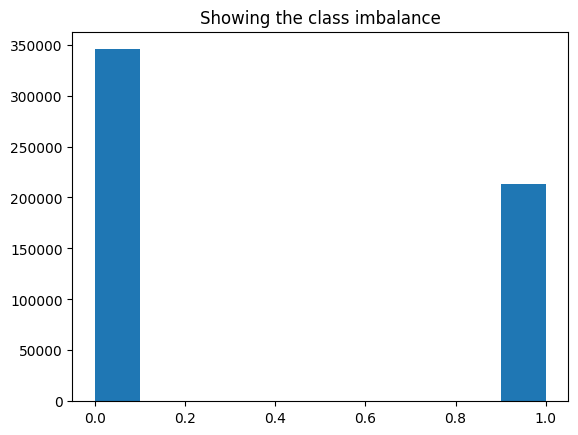

The Class Imbalance: Counter({0: 345415, 1: 212796})


In [ ]:
classes = df_enriched['PotentialFraud'].to_numpy()

plt.hist(classes)
plt.title("Showing the class imbalance")
plt.show()

print('The Class Imbalance: %s' % Counter(classes))

In [ ]:
df_enriched.head()

,AttendingPhysician,BeneID,Provider,ClaimID,InscClaimAmtReimbursed,DeductibleAmtPaid,PotentialFraud,Gender,Race,NoOfMonths_PartACov,...,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Provider_degree,Provider_eigenvector_centrality,Provider_pagerank,AttendingPhysician_degree,AttendingPhysician_eigenvector_centrality,AttendingPhysician_pagerank,AttendingPhysician_cluster
0,2000000,3100026,1051154,4327937,50,0.0,0,2,2,12,...,0,730,120,4,0.022443,0.000022,905,0.688022,0.003687,3
1,2000000,3100075,1052723,4381108,0,0.0,0,2,1,12,...,4272,9510,3130,5,0.022467,0.000027,905,0.688022,0.003687,3
2,2000000,3100125,1052145,4543156,90,10.0,0,1,1,12,...,0,1460,580,51,0.023621,0.000280,905,0.688022,0.003687,3
3,2000000,3100140,1053762,4149709,100,0.0,1,1,1,12,...,0,1880,110,96,0.024900,0.000524,905,0.688022,0.003687,3
4,2000000,3100200,1055912,4413025,20,0.0,1,2,1,12,...,1068,20,20,69,0.024105,0.000371,905,0.688022,0.003687,3


In [ ]:
# Splitting feature data from label data
X, y = df_enriched[['InscClaimAmtReimbursed',
                    'DeductibleAmtPaid',
                    'Gender',
                    'Race',
                    'NoOfMonths_PartACov',
                    'NoOfMonths_PartBCov',
                    'IPAnnualReimbursementAmt',
                    'IPAnnualDeductibleAmt',
                    'OPAnnualReimbursementAmt',
                    'OPAnnualDeductibleAmt',
                    'Provider_degree',
                    #  'Provider_closeness_centrality',
                    'Provider_eigenvector_centrality',
                    'Provider_pagerank',
                    'AttendingPhysician_degree',
                    #  'AttendingPhysician_closeness_centrality',
                    'AttendingPhysician_eigenvector_centrality',
                    'AttendingPhysician_pagerank',
                    'AttendingPhysician_cluster']], df_enriched['PotentialFraud']

print("Original shapes: ", "X:", X.shape, " y:", y.shape)

Original shapes:  X: (558211, 17)  y: (558211,)


In [ ]:
X = X.fillna(0)

In [ ]:
 # Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)
print(f"Shapes after splitting:\n\nX_train: {X_train.shape}, y_train: {y_train.shape}\
      \nX_test: {X_test.shape}, y_test: {y_test.shape}")

Shapes after splitting:

X_train: (390747, 17), y_train: (390747,)     
X_test: (167464, 17), y_test: (167464,)


Logistic Regression

In [ ]:
log_reg_1 = LogisticRegression(C=0.0316228, penalty='l1',
                               fit_intercept=True, solver='liblinear', tol=0.0001, max_iter=500,
                               class_weight='balanced',
                               verbose=0,
                               intercept_scaling=1.0,
                               multi_class='auto',
                               random_state=49)

log_reg_1.fit(X_train, y_train)

LogisticRegression(C=0.0316228, class_weight='balanced', intercept_scaling=1.0,
                   max_iter=500, penalty='l1', random_state=49,
                   solver='liblinear')

In [ ]:
log_reg_1.score(X_test, y_test)

0.6638680552238093

Decision Tree

In [ ]:
dec_tree_2 = DecisionTreeClassifier(criterion='gini',
                                   max_depth= 6,
                                   max_features='log2',
                                   min_samples_leaf=100,
                                   min_samples_split=100,
                                   class_weight='balanced',
                                   random_state=49,
                                   splitter='best',
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

dec_tree_2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       max_features='log2', min_samples_leaf=100,
                       min_samples_split=100, random_state=49)

In [ ]:
dec_tree_2.score(X_test, y_test)

0.7195158362394306

Random Forest

In [ ]:
rfc_3 = RandomForestClassifier(n_estimators=30,criterion='gini',
                                   max_depth= 7,
                                   max_features='auto',
                                   min_samples_leaf=60,
                                   min_samples_split=50,
                                   class_weight='balanced',
                                   random_state=49,
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

rfc_3.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7,
                       max_features='auto', min_samples_leaf=60,
                       min_samples_split=50, n_estimators=30, random_state=49)

In [ ]:
rfc_3.score(X_test, y_test)

0.7454975397697415

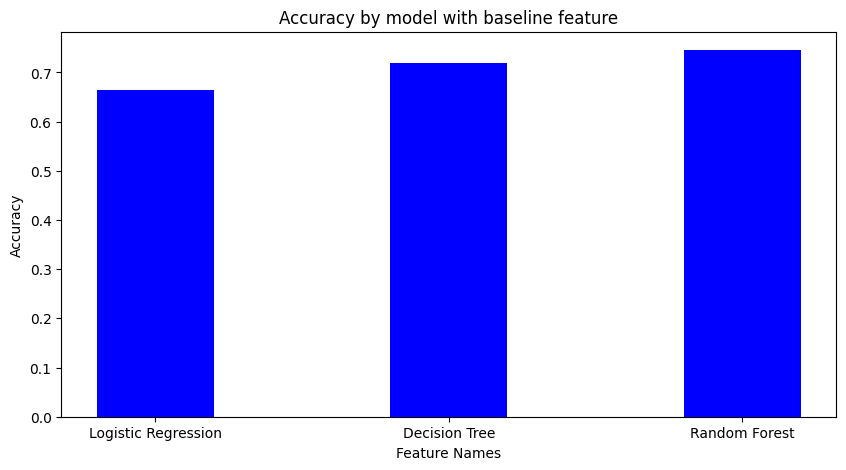

In [ ]:
acc=[0.6638680552238093,0.7195158362394306,
0.7454975397697415]
model_names=['Logistic Regression','Decision Tree','Random Forest']
fig = plt.figure(figsize = (10, 5))


# creating the bar plot
plt.bar(model_names, acc, color ='blue',
        width = 0.4)

plt.xlabel("Feature Names")
plt.ylabel("Accuracy")
plt.title("Accuracy by model with baseline feature")
plt.show()

In [ ]:
accuracy = []
feature_names = ["Baseline", "Graph Features", "Graph Features with Community Detection"]
features = [
    # Baseline features
    ['InscClaimAmtReimbursed',
     'DeductibleAmtPaid',
     'Gender',
     'Race',
     'NoOfMonths_PartACov',
     'NoOfMonths_PartBCov',
     'IPAnnualReimbursementAmt',
     'IPAnnualDeductibleAmt',
     'OPAnnualReimbursementAmt',
     'OPAnnualDeductibleAmt'],
    # Baseline + Graph Features
    ['InscClaimAmtReimbursed',
     'DeductibleAmtPaid',
     'Gender',
     'Race',
     'NoOfMonths_PartACov',
     'NoOfMonths_PartBCov',
     'IPAnnualReimbursementAmt',
     'IPAnnualDeductibleAmt',
     'OPAnnualReimbursementAmt',
     'OPAnnualDeductibleAmt',
     'Provider_degree',
    #  'Provider_closeness_centrality',
     'Provider_eigenvector_centrality',
     'Provider_pagerank',
     'AttendingPhysician_degree',
    #  'AttendingPhysician_closeness_centrality',
     'AttendingPhysician_eigenvector_centrality',
    'AttendingPhysician_pagerank'],
    # Baseline + Graph Features + Community Detection
    ['InscClaimAmtReimbursed',
     'DeductibleAmtPaid',
     'Gender',
     'Race',
     'NoOfMonths_PartACov',
     'NoOfMonths_PartBCov',
     'IPAnnualReimbursementAmt',
     'IPAnnualDeductibleAmt',
     'OPAnnualReimbursementAmt',
     'OPAnnualDeductibleAmt',
     'Provider_degree',
    #  'Provider_closeness_centrality',
     'Provider_eigenvector_centrality',
     'Provider_pagerank',
     'AttendingPhysician_degree',
    #  'AttendingPhysician_closeness_centrality',
     'AttendingPhysician_eigenvector_centrality',
    'AttendingPhysician_pagerank',
     'AttendingPhysician_cluster']
]

hyper_parameter_grids_RFC = [
    { # Grid 1: No regularization
      "randomforestclassifier__criterion": ['gini'],
      "randomforestclassifier__max_depth": [10, 20, 50, 100, 250, 300, 500],
      "randomforestclassifier__min_samples_split": [2, 3, 5, 10, 20, 30],
    },
    { # Grid 2: L2 regularization
      "randomforestclassifier__criterion": ['entropy'],
      "randomforestclassifier__max_depth": [10, 20, 50, 100, 250, 300, 500],
      "randomforestclassifier__min_samples_split": [2, 3, 5, 10, 20, 30],

    },
]

pipeline_RFC = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=69))


for feature in features:
    print("*" * 100)
    print("# Tuning hyper-parameters for accuracy")
    print("*" * 100)
    print()

    # This performs gridsearch, evaluating each set of hyper-parameters using k-fold
    # cross validation.
    clf = HalvingGridSearchCV(pipeline_RFC, hyper_parameter_grids_RFC, scoring="accuracy", cv=4, n_jobs=-1)

    X_train_subset = X_train[feature]
    X_test_subset = X_test[feature]

    clf.fit(X_train_subset, y_train)

    acc = round(clf.best_estimator_.score(X_test_subset, y_test) * 100, 2)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Best score on development set:")
    print()

    print(f"Accuracy: {acc}")
    accuracy.append(acc)

****************************************************************************************************
# Tuning hyper-parameters for accuracy
****************************************************************************************************

Best parameters set found on development set:

{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 3}

Best score on development set:

Accuracy: 63.18
****************************************************************************************************
# Tuning hyper-parameters for accuracy
****************************************************************************************************

Best parameters set found on development set:

{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 300, 'randomforestclassifier__min_samples_split': 2}

Best score on development set:

Accuracy: 95.76
***********************************************

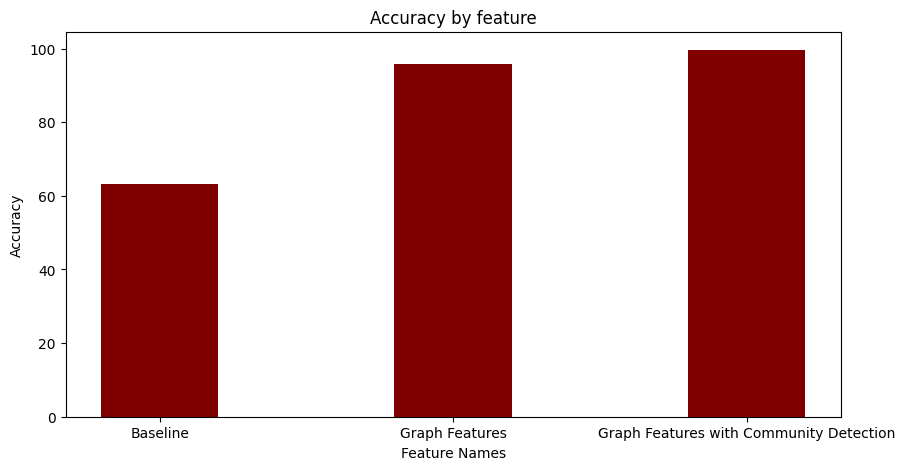

In [ ]:
fig = plt.figure(figsize = (10, 5))


# creating the bar plot
plt.bar(feature_names, accuracy, color ='maroon',
        width = 0.4)

plt.xlabel("Feature Names")
plt.ylabel("Accuracy")
plt.title("Accuracy by feature")
plt.show()


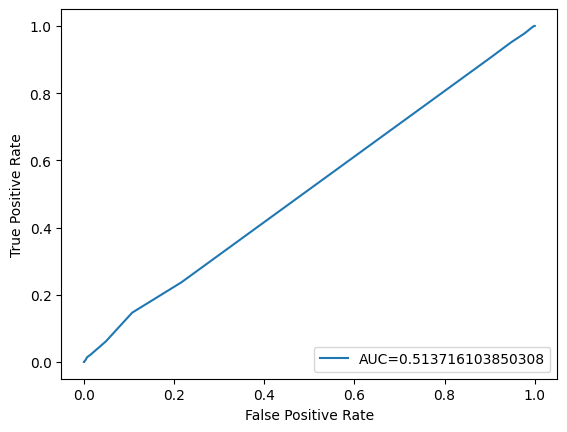

In [ ]:

#define metrics
y_pred_proba = clf.best_estimator_.steps[1][1].predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
bar_data = pd.DataFrame(
   dict(
      labels = list(X_train.columns),
      feature_importance = clf.best_estimator_.steps[1][1].feature_importances_
   )
)

bar_data = bar_data.sort_values('feature_importance', ascending=False)

bar_data.plot(x="labels", y="feature_importance", kind="bar")